<a href="https://cognitiveclass.ai/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkRP0321ENSkillsNetwork25371262-2021-01-01">
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-RP0101EN-Coursera/v2/M1_R_Basics/images/IDSNlogo.png" width="200" align="center">
</a>


<h1>Refine the Baseline Regression Models</h1>

Estimated time needed: **120** minutes


## Lab Overview:

Now you have built a baseline regression model with some relatively good RMSE and R-squared reported values. However, we could still improve it by using methods like adding polynomial and interaction terms, regularization, and so on.

In this lab, you will be asked to continue using `tidymodels` to improve the performance of baseline model:

*   **TASK: Add polynomial terms**
*   **TASK: Add interactions terms**
*   **TASK: Add regularizations terms**
*   **TASK: Experiment to search for improved models**

Let's start!


First install and import necessary libraries


In [1]:
# Check whether you need to install `rlang` and `tidymodels` libraries
#install.packages("rlang")
#install.packages("tidymodels")

In [2]:
library("tidymodels")
library("tidyverse")
library("stringr")

Registered S3 method overwritten by 'tune':
  method                   from   
  required_pkgs.model_spec parsnip

── Attaching packages ────────────────────────────────────── tidymodels 0.1.4 ──

✔ broom        0.7.12     ✔ recipes      0.1.17
✔ dials        0.1.0      ✔ rsample      0.1.1 
✔ dplyr        1.0.7      ✔ tibble       3.1.6 
✔ ggplot2      3.3.5      ✔ tidyr        1.1.4 
✔ infer        1.0.0      ✔ tune         0.1.6 
✔ modeldata    0.1.1      ✔ workflows    0.2.4 
✔ parsnip      0.1.7      ✔ workflowsets 0.1.0 
✔ purrr        0.3.4      ✔ yardstick    0.0.9 

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ purrr::discard() masks scales::discard()
✖ dplyr::filter()  masks stats::filter()
✖ dplyr::lag()     masks stats::lag()
✖ recipes::step()  masks stats::step()
• Dig deeper into tidy modeling with R at https://www.tmwr.org

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ readr   2.1.2     ✔ forcats 

The processed Seoul bike sharing dataset `seoul_bike_sharing_converted_normalized.csv`,  includes the converted indicator variables, and the numerical variables have been normalized.
Let's read it as a dataframe first:


In [3]:
# Dataset URL
dataset_url <- "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-RP0321EN-SkillsNetwork/labs/datasets/seoul_bike_sharing_converted_normalized.csv"
bike_sharing_df <- read_csv(dataset_url)
spec(bike_sharing_df)

Rows: 8465 Columns: 41
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): DATE, FUNCTIONING_DAY
dbl (39): RENTED_BIKE_COUNT, TEMPERATURE, HUMIDITY, WIND_SPEED, VISIBILITY, ...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


cols(
  DATE = col_character(),
  RENTED_BIKE_COUNT = col_double(),
  TEMPERATURE = col_double(),
  HUMIDITY = col_double(),
  WIND_SPEED = col_double(),
  VISIBILITY = col_double(),
  DEW_POINT_TEMPERATURE = col_double(),
  SOLAR_RADIATION = col_double(),
  RAINFALL = col_double(),
  SNOWFALL = col_double(),
  FUNCTIONING_DAY = col_character(),
  `0` = col_double(),
  `1` = col_double(),
  `10` = col_double(),
  `11` = col_double(),
  `12` = col_double(),
  `13` = col_double(),
  `14` = col_double(),
  `15` = col_double(),
  `16` = col_double(),
  `17` = col_double(),
  `18` = col_double(),
  `19` = col_double(),
  `2` = col_double(),
  `20` = col_double(),
  `21` = col_double(),
  `22` = col_double(),
  `23` = col_double(),
  `3` = col_double(),
  `4` = col_double(),
  `5` = col_double(),
  `6` = col_double(),
  `7` = col_double(),
  `8` = col_double(),
  `9` = col_double(),
  AUTUMN = col_double(),
  SPRING = col_double(),
  SUMMER = col_double(),
  WINTER = col_double(),
  HOLIDAY 

We won't be using the `DATE` column, because 'as is', it basically acts like an data entry index. (However, given more time, we could use the `DATE` colum to create a 'day of week' or 'isWeekend' column, which we might expect has an affect on preferred bike rental times.) We also do not need the `FUNCTIONAL DAY` column because it only has one distinct value remaining (`YES`) after missing value processing.


In [4]:
bike_sharing_df <- bike_sharing_df %>% 
                   select(-DATE, -FUNCTIONING_DAY)

Define a linear regression model specification.


In [5]:
lm_spec <- linear_reg() %>%
  set_engine("lm") %>% 
  set_mode("regression")

Split the data into training and testing datasets.


In [6]:
set.seed(1234)
data_split <- initial_split(bike_sharing_df, prop = 4/5)
train_data <- training(data_split)
test_data <- testing(data_split)

Now we are ready to refine the previous baseline regression model.


# TASK: Add polynomial terms


Linear regression models are the most suitable models to capture the linear correlations among variables. However, in real world data, many relationships may be non-linear.


For example, the correlation between `RENTED_BIKE_COUNT` and `TEMPERATURE` does not look like linear:


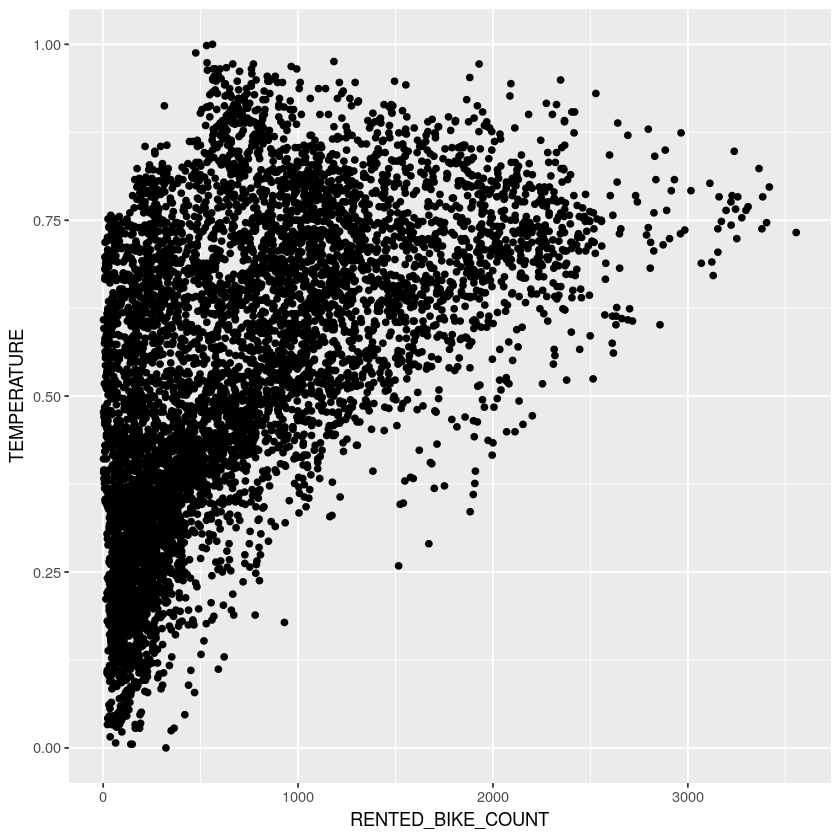

In [7]:
ggplot(data = train_data, aes(RENTED_BIKE_COUNT, TEMPERATURE)) + 
    geom_point() 

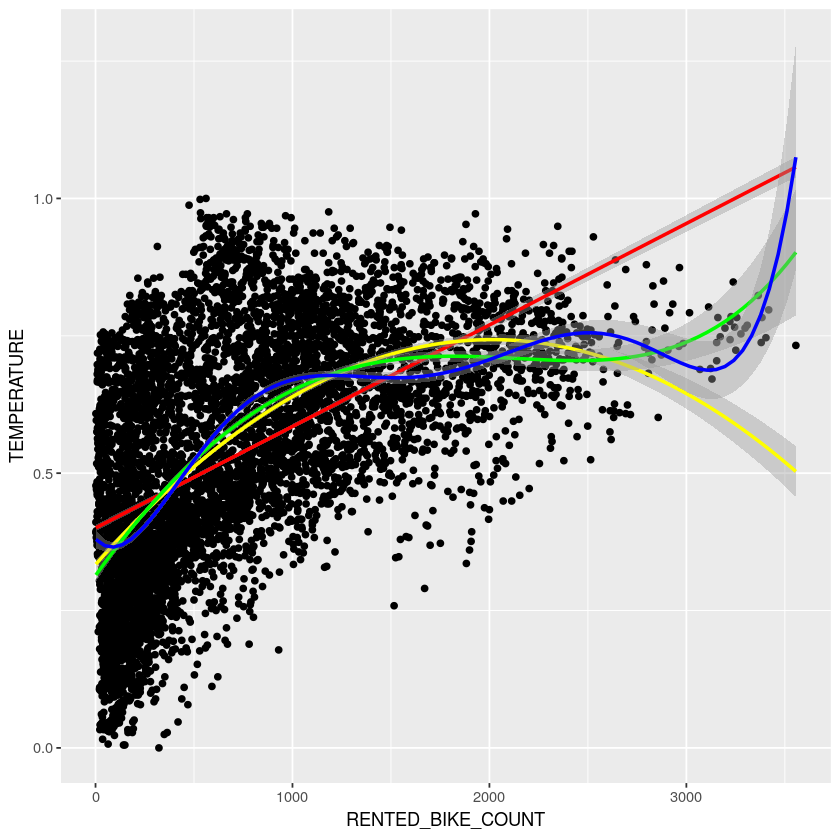

In [8]:
# Plot the higher order polynomial fits
ggplot(data=train_data, aes(RENTED_BIKE_COUNT, TEMPERATURE)) + 
    geom_point() + 
    geom_smooth(method = "lm", formula = y ~ x, color="red") + 
    geom_smooth(method = "lm", formula = y ~ poly(x, 2), color="yellow") + 
    geom_smooth(method = "lm", formula = y ~ poly(x, 4), color="green") + 
    geom_smooth(method = "lm", formula = y ~ poly(x, 6), color="blue")

OK, let's add some higher order polynomials of important variables to the regression models


*TODO:* Fit a linear regression model `lm_poly` with higher order polynomial terms on the important variables (larger coefficients) found in the baseline model


In [9]:
# Fit a linear model with higher order polynomial on some important variables 

# #HINT: Use ploy function to build polynomial terms, lm_poly <- RENTED_BIKE_COUNT ~ poly(TEMPERATURE, 6) + 
##poly(HUMIDITY, 4) .....

lm_poly <- lm_spec %>%
  fit(RENTED_BIKE_COUNT ~ poly(TEMPERATURE, 6) + poly(HUMIDITY, 4) + poly(WIND_SPEED, 4) + poly(VISIBILITY, 8) +
      poly(DEW_POINT_TEMPERATURE, 4) + poly(SOLAR_RADIATION, 6) + poly(RAINFALL, 6) + poly(SNOWFALL, 6), 
      data = train_data)

In [10]:
# Print model summary

# summary(lm_poly$fit)
summary(lm_poly$fit)


Call:
stats::lm(formula = RENTED_BIKE_COUNT ~ poly(TEMPERATURE, 6) + 
    poly(HUMIDITY, 4) + poly(WIND_SPEED, 4) + poly(VISIBILITY, 
    8) + poly(DEW_POINT_TEMPERATURE, 4) + poly(SOLAR_RADIATION, 
    6) + poly(RAINFALL, 6) + poly(SNOWFALL, 6), data = data)

Residuals:
     Min       1Q   Median       3Q      Max 
-1487.78  -238.83   -41.19   191.67  1879.19 

Coefficients:
                                  Estimate Std. Error t value Pr(>|t|)    
(Intercept)                        734.851      5.089 144.391  < 2e-16 ***
poly(TEMPERATURE, 6)1            63450.358   5592.328  11.346  < 2e-16 ***
poly(TEMPERATURE, 6)2             8667.691    893.768   9.698  < 2e-16 ***
poly(TEMPERATURE, 6)3           -10916.075    598.975 -18.225  < 2e-16 ***
poly(TEMPERATURE, 6)4            -6753.360    545.496 -12.380  < 2e-16 ***
poly(TEMPERATURE, 6)5              127.884    473.582   0.270 0.787141    
poly(TEMPERATURE, 6)6              721.809    433.901   1.664 0.096252 .  
poly(HUMIDITY, 4)1  

*TODO:* Make predictions on test dataset using the `lm_poly` models


In [11]:
# Use predict() function to generate test results for `lm_poly`
test_results <- lm_poly %>%
  predict(new_data = test_data) %>%
  mutate(truth = test_data$RENTED_BIKE_COUNT)
#head(test_results)

Another minor improvement we could do here is to convert all negative prediction results to zero, because we can not have negative rented bike counts


In [12]:
# e.g., test_results[test_results<0] <- 0
test_results[test_results<0] <- 0

Now, calculate R-squared and RMSE for the test results generated by `lm_ploy` model


In [13]:
# Calculate R-squared and RMSE from the test results
rsq(test_results, truth = truth,
    estimate = .pred)
rmse(test_results, truth = truth,
     estimate = .pred)

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rsq,standard,0.5800577


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,410.2241


If you include all variables, and additionally include some of the more important ones as higher order poly terms, then you should notice improved  `R-squared` and `RMSE` values.


# TASK: Add interaction terms


In real-world scenarios, in addition to non-linear relationships between response variables and predictor variables, you may also encounter relationships among variables called `interaction effects`.

For example, the effect of predictor variable `TEMPERATURE` on `RENTED_BIKE_COUNT` may also depend on other variables such as `HUMIDITY`, `RAINFALL`, or both (they `interact`) and the effect of `SEASON` on `RENTED_BIKE_COUNT` may also depend on `HOLIDAY`, `HOUR`, or both.

To capture such interaction effects, we could add some interaction terms such as `RAINFALL*HUMIDITY` to the regression model, similar to what we did with polynominal terms. In this task, you will explore and conduct some experiments to search for interaction terms which will improve the model performance.


*TODO:* Try adding some interaction terms to the previous polynomial models.


In [14]:
# Add interaction terms to the poly regression built in previous step

# HINT: You could use `*` operator to create interaction terms such as HUMIDITY*TEMPERATURE and make the formula look like:
# RENTED_BIKE_COUNT ~ RAINFALL*HUMIDITY ...
lm_poly1 <- lm_spec %>%
  fit(RENTED_BIKE_COUNT ~ poly(TEMPERATURE, 6) + poly(HUMIDITY, 4) + poly(WIND_SPEED, 4) + poly(VISIBILITY, 8) +
      poly(DEW_POINT_TEMPERATURE, 4) + poly(SOLAR_RADIATION, 6) + poly(RAINFALL, 6) + poly(SNOWFALL, 6) +
      HUMIDITY*TEMPERATURE + RAINFALL*HUMIDITY + TEMPERATURE*WIND_SPEED + TEMPERATURE*VISIBILITY +
      TEMPERATURE*DEW_POINT_TEMPERATURE + TEMPERATURE*SOLAR_RADIATION + TEMPERATURE*RAINFALL + TEMPERATURE*SNOWFALL +
      HUMIDITY*WIND_SPEED + HUMIDITY*VISIBILITY + HUMIDITY*DEW_POINT_TEMPERATURE + HUMIDITY*SOLAR_RADIATION +
      HUMIDITY*SNOWFALL + WIND_SPEED*VISIBILITY + WIND_SPEED*DEW_POINT_TEMPERATURE + WIND_SPEED*SOLAR_RADIATION +
      WIND_SPEED*RAINFALL + WIND_SPEED*SNOWFALL + VISIBILITY*DEW_POINT_TEMPERATURE + VISIBILITY*SOLAR_RADIATION +
      VISIBILITY*RAINFALL + VISIBILITY*SNOWFALL + DEW_POINT_TEMPERATURE*SOLAR_RADIATION + 
      DEW_POINT_TEMPERATURE*RAINFALL + DEW_POINT_TEMPERATURE*SNOWFALL + SOLAR_RADIATION*RAINFALL + 
      SOLAR_RADIATION*SNOWFALL + RAINFALL*SNOWFALL, data = train_data)

In [15]:
# Print model summary
summary(lm_poly1$fit)


Call:
stats::lm(formula = RENTED_BIKE_COUNT ~ poly(TEMPERATURE, 6) + 
    poly(HUMIDITY, 4) + poly(WIND_SPEED, 4) + poly(VISIBILITY, 
    8) + poly(DEW_POINT_TEMPERATURE, 4) + poly(SOLAR_RADIATION, 
    6) + poly(RAINFALL, 6) + poly(SNOWFALL, 6) + HUMIDITY * TEMPERATURE + 
    RAINFALL * HUMIDITY + TEMPERATURE * WIND_SPEED + TEMPERATURE * 
    VISIBILITY + TEMPERATURE * DEW_POINT_TEMPERATURE + TEMPERATURE * 
    SOLAR_RADIATION + TEMPERATURE * RAINFALL + TEMPERATURE * 
    SNOWFALL + HUMIDITY * WIND_SPEED + HUMIDITY * VISIBILITY + 
    HUMIDITY * DEW_POINT_TEMPERATURE + HUMIDITY * SOLAR_RADIATION + 
    HUMIDITY * SNOWFALL + WIND_SPEED * VISIBILITY + WIND_SPEED * 
    DEW_POINT_TEMPERATURE + WIND_SPEED * SOLAR_RADIATION + WIND_SPEED * 
    RAINFALL + WIND_SPEED * SNOWFALL + VISIBILITY * DEW_POINT_TEMPERATURE + 
    VISIBILITY * SOLAR_RADIATION + VISIBILITY * RAINFALL + VISIBILITY * 
    SNOWFALL + DEW_POINT_TEMPERATURE * SOLAR_RADIATION + DEW_POINT_TEMPERATURE * 
    RAINFALL + DEW_PO

In [16]:
test_results1 <- lm_poly1 %>%
  predict(new_data = test_data) %>%
  mutate(truth = test_data$RENTED_BIKE_COUNT)
#head(test_results1)

Warning message in predict.lm(object = object$fit, newdata = new_data, type = "response"):
“prediction from a rank-deficient fit may be misleading”


In [17]:
# Calculate R-squared and RMSE for the new model to see if performance has improved
rsq(test_results1, truth = truth,
    estimate = .pred)
rmse(test_results1, truth = truth,
     estimate = .pred)

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rsq,standard,0.5900638


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,405.2858


# TASK: Add regularization


In previous tasks, you were asked to add polynominal and interaction terms to the model, aiming to capture nonlinearity and interaction effects between the predictor variables. Hopefully, your updated models have better R-squared and RMSE values.

However, adding these terms makes your model more complicated, more difficult to explain, and more likely to suffer from overfitting. To overcome these issues, one solution is to add regularization terms to your models.


When building the baseline model, we used the basic `lm` engine. In this task, you will use a more advanced and generalized `glmnet` engine. It provides a generalized linear model with Lasso, Ridge, and Elastic Net regularizations.

In general, using `glmnet` can enhance your models in the following ways:

*   Address overfitting issues by shrinking the coefficients
*   Address predictor variable colinearity by selecting only one variable from each group of colinear variables (by shrinking their coefficients to zero)
*   Make your models more interpretable due to simplification (fewer variables in the outcome models)


Now, let's switch our regression engine to `glmnet`


In [18]:
#install.packages('glmnet')
library('glmnet')

Loading required package: Matrix


Attaching package: ‘Matrix’


The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack


Loaded glmnet 4.1-3



In [19]:
#weather_recipe <-
#  recipe(RENTED_BIKE_COUNT ~ ., data = train_data)

In [20]:
rec <- 
  recipe(RENTED_BIKE_COUNT ~ ., data = train_data)

weather_recipe <- rec %>%
  step_poly(TEMPERATURE, HUMIDITY, WIND_SPEED, VISIBILITY, DEW_POINT_TEMPERATURE, SOLAR_RADIATION, RAINFALL, 
            SNOWFALL, degree=8)
weather_recipe <- prep(weather_recipe, data = train_data)

*TODO:* Define a linear regression model specification `glmnet_spec` using `glmnet` engine


In [21]:
# HINT: Use linear_reg() function with two parameters: penalty and mixture
# - penalty controls the intensity of model regularization
# - mixture controls the tradeoff between L1 and L2 regularizations

# You could manually try different parameter combinations or use grid search to find optimal combinations
glmnet_spec <- linear_reg(penalty = 0.1, mixture = 0) %>%   # ridge
  # Set engine
  set_engine("glmnet")

glmnet_spec1 <- linear_reg(penalty = 0.1, mixture = 1) %>%  # lasso
  # Set engine
  set_engine("glmnet")

glmnet_spec2 <- linear_reg(penalty = 0.1, mixture = 0.5) %>%  # elastic net
  # Set engine
  set_engine("glmnet")

Fit a glmnet model called  `lm_glmnet` using the `fit()` function. For the formula part, keep the polynominal and interaction terms you used in the previous task.


In [22]:
# Fit a glmnet model using the fit() function
ridge_wf <- workflow() %>%
  add_recipe(weather_recipe)
ridge_fit <- ridge_wf %>%
  add_model(glmnet_spec) %>%
  fit(data = train_data)
ridge_fit %>%
  extract_fit_parsnip() %>%
  tidy()

term,estimate,penalty
<chr>,<dbl>,<dbl>
(Intercept),690.197929,0.1
0,16.464052,0.1
1,-92.762783,0.1
10,-375.887982,0.1
11,-324.868235,0.1
12,-221.323091,0.1
13,-214.171173,0.1
14,-201.533053,0.1
15,-149.334868,0.1


In [23]:
lasso_wf <- workflow() %>%
  add_recipe(weather_recipe)
lasso_fit <- lasso_wf %>%
  add_model(glmnet_spec1) %>%
  fit(data = train_data)
lasso_fit %>%
  extract_fit_parsnip() %>%
  tidy()

term,estimate,penalty
<chr>,<dbl>,<dbl>
(Intercept),612.480459,0.1
0,224.639434,0.1
1,108.529439,0.1
10,-359.817608,0.1
11,-307.282059,0.1
12,-196.876297,0.1
13,-192.973980,0.1
14,-185.929280,0.1
15,-134.859730,0.1


In [24]:
elasticnet_wf <- workflow() %>%
  add_recipe(weather_recipe)
elasticnet_fit <- elasticnet_wf %>%
  add_model(glmnet_spec2) %>%
  fit(data = train_data)
elasticnet_fit %>%
  extract_fit_parsnip() %>%
  tidy()

term,estimate,penalty
<chr>,<dbl>,<dbl>
(Intercept),567.368515,0.1
0,215.404525,0.1
1,99.334806,0.1
10,-370.135394,0.1
11,-317.708014,0.1
12,-207.402005,0.1
13,-203.485215,0.1
14,-196.333182,0.1
15,-145.154590,0.1


In [25]:
test_results_ridge <- ridge_fit %>%
  # Make the predictions and save the predicted values
  predict(new_data = test_data) %>%
  # Create a new column to save the true values
  mutate(truth = test_data$RENTED_BIKE_COUNT)

In [26]:
test_results_lasso <- lasso_fit %>%
  # Make the predictions and save the predicted values
  predict(new_data = test_data) %>%
  # Create a new column to save the true values
  mutate(truth = test_data$RENTED_BIKE_COUNT)

In [27]:
test_results_elasticnet <- elasticnet_fit %>%
  # Make the predictions and save the predicted values
  predict(new_data = test_data) %>%
  # Create a new column to save the true values
  mutate(truth = test_data$RENTED_BIKE_COUNT)

In [28]:
# Report rsq and rmse of the `lm_glmnet` model
rsq(test_results_ridge, truth = truth,
    estimate = .pred)
rsq(test_results_lasso, truth = truth,
    estimate = .pred)
rsq(test_results_elasticnet, truth = truth,
    estimate = .pred)

rmse(test_results_ridge, truth = truth,
     estimate = .pred)
rmse(test_results_lasso, truth = truth,
     estimate = .pred)
rmse(test_results_elasticnet, truth = truth,
     estimate = .pred)

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rsq,standard,0.7645112


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rsq,standard,0.7685309


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rsq,standard,0.7685045


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,308.2321


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,304.6527


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,304.6712


# TASK: Experiment to search for improved models


Now you understand some of the methods that you can use to try to improve your models.


*TODO:* Experiment by building and testing at least five different models. For each of your experiments, include polynomial terms, interaction terms, and one of the three regularizations we introduced.


In [29]:
# Build at least five different models using polynomial terms, interaction terms, and regularizations.
ridge_spec <- linear_reg(penalty = 1, mixture = 0) %>%   # ridge
  # Set engine
  set_engine("glmnet")

lasso_spec <- linear_reg(penalty = 1, mixture = 1) %>%  # lasso
  # Set engine
  set_engine("glmnet")

elasticnet_spec <- linear_reg(penalty = 1, mixture = 0.5) %>%  # elastic net
  # Set engine
  set_engine("glmnet")

elasticnet_spec1 <- linear_reg(penalty = 1, mixture = 0.3) %>%  # elastic net
  # Set engine
  set_engine("glmnet")

elasticnet_spec2 <- linear_reg(penalty = 1, mixture = 0.1) %>%  # elastic net
  # Set engine
  set_engine("glmnet")

# Save their rmse and rsq values


In [30]:
ridge_wf1 <- workflow() %>%
  add_recipe(weather_recipe)
ridge_fit1 <- ridge_wf1 %>%
  add_model(ridge_spec) %>%
  fit(data = train_data)
ridge_fit1 %>%
  extract_fit_parsnip() %>%
  tidy()

term,estimate,penalty
<chr>,<dbl>,<dbl>
(Intercept),690.197929,1
0,16.464052,1
1,-92.762783,1
10,-375.887982,1
11,-324.868235,1
12,-221.323091,1
13,-214.171173,1
14,-201.533053,1
15,-149.334868,1


In [31]:
lasso_wf1 <- workflow() %>%
  add_recipe(weather_recipe)
lasso_fit1 <- lasso_wf1 %>%
  add_model(lasso_spec) %>%
  fit(data = train_data)
lasso_fit1 %>%
  extract_fit_parsnip() %>%
  tidy()

term,estimate,penalty
<chr>,<dbl>,<dbl>
(Intercept),602.6684552,1
0,204.0169425,1
1,88.5537227,1
10,-317.9765249,1
11,-264.2738299,1
12,-153.5443875,1
13,-149.0686733,1
14,-142.8615007,1
15,-93.1714556,1


In [32]:
elasticnet_wf1 <- workflow() %>%
  add_recipe(weather_recipe)
elasticnet_fit1 <- elasticnet_wf1 %>%
  add_model(elasticnet_spec) %>%
  fit(data = train_data)
elasticnet_fit1 %>%
  extract_fit_parsnip() %>%
  tidy()

term,estimate,penalty
<chr>,<dbl>,<dbl>
(Intercept),562.6835870,1
0,207.5092171,1
1,91.7397157,1
10,-349.6105926,1
11,-296.6532076,1
12,-186.1894805,1
13,-181.9680100,1
14,-175.1193439,1
15,-124.5150151,1


In [33]:
elasticnet_wf2 <- workflow() %>%
  add_recipe(weather_recipe)
elasticnet_fit2 <- elasticnet_wf2 %>%
  add_model(elasticnet_spec1) %>%
  fit(data = train_data)
elasticnet_fit2 %>%
  extract_fit_parsnip() %>%
  tidy()

term,estimate,penalty
<chr>,<dbl>,<dbl>
(Intercept),583.651221,1
0,198.001259,1
1,82.153354,1
10,-374.991830,1
11,-322.462801,1
12,-212.231849,1
13,-208.169010,1
14,-200.982956,1
15,-149.941934,1


In [34]:
elasticnet_wf3 <- workflow() %>%
  add_recipe(weather_recipe)
elasticnet_fit3 <- elasticnet_wf3 %>%
  add_model(elasticnet_spec2) %>%
  fit(data = train_data)
elasticnet_fit3 %>%
  extract_fit_parsnip() %>%
  tidy()

term,estimate,penalty
<chr>,<dbl>,<dbl>
(Intercept),650.43197,1
0,139.60804,1
1,23.65496,1
10,-445.26548,1
11,-392.92695,1
12,-282.85074,1
13,-278.81991,1
14,-271.51407,1
15,-220.30120,1


In [35]:
test_results_ridge1 <- ridge_fit1 %>%
  # Make the predictions and save the predicted values
  predict(new_data = test_data) %>%
  # Create a new column to save the true values
  mutate(truth = test_data$RENTED_BIKE_COUNT)

In [36]:
test_results_lasso1 <- lasso_fit1 %>%
  # Make the predictions and save the predicted values
  predict(new_data = test_data) %>%
  # Create a new column to save the true values
  mutate(truth = test_data$RENTED_BIKE_COUNT)

In [37]:
test_results_elasticnet1 <- elasticnet_fit1 %>%
  # Make the predictions and save the predicted values
  predict(new_data = test_data) %>%
  # Create a new column to save the true values
  mutate(truth = test_data$RENTED_BIKE_COUNT)

In [38]:
test_results_elasticnet2 <- elasticnet_fit2 %>%
  # Make the predictions and save the predicted values
  predict(new_data = test_data) %>%
  # Create a new column to save the true values
  mutate(truth = test_data$RENTED_BIKE_COUNT)

In [39]:
test_results_elasticnet3 <- elasticnet_fit3 %>%
  # Make the predictions and save the predicted values
  predict(new_data = test_data) %>%
  # Create a new column to save the true values
  mutate(truth = test_data$RENTED_BIKE_COUNT)

In [40]:
rsq(test_results_ridge1, truth = truth,
    estimate = .pred)
rsq(test_results_lasso1, truth = truth,
    estimate = .pred)
rsq(test_results_elasticnet1, truth = truth,
    estimate = .pred)
rsq(test_results_elasticnet2, truth = truth,
    estimate = .pred)
rsq(test_results_elasticnet3, truth = truth,
    estimate = .pred)

rmse(test_results_ridge1, truth = truth,
     estimate = .pred)
rmse(test_results_lasso1, truth = truth,
     estimate = .pred)
rmse(test_results_elasticnet1, truth = truth,
     estimate = .pred)
rmse(test_results_elasticnet2, truth = truth,
     estimate = .pred)
rmse(test_results_elasticnet3, truth = truth,
     estimate = .pred)

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rsq,standard,0.7645112


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rsq,standard,0.7688183


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rsq,standard,0.768742


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rsq,standard,0.7686181


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rsq,standard,0.7684817


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,308.2321


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,304.561


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,304.5503


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,304.6139


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,304.6862


In [41]:
# Save their rmse and rsq values
rsq_ridge = rsq(test_results_ridge, truth = truth,
    estimate = .pred)
rsq_lasso = rsq(test_results_lasso, truth = truth,
    estimate = .pred)
rsq_elasticnet = rsq(test_results_elasticnet, truth = truth,
    estimate = .pred)

rmse_ridge = rmse(test_results_ridge, truth = truth,
     estimate = .pred)
rmse_lasso = rmse(test_results_lasso, truth = truth,
     estimate = .pred)
rmse_elasticnet = rmse(test_results_elasticnet, truth = truth,
     estimate = .pred)

rsq_lm_poly = rsq(test_results, truth = truth,
    estimate = .pred)
rsq_lm_poly1 = rsq(test_results1, truth = truth,
    estimate = .pred)

rmse_lm_poly = rmse(test_results, truth = truth,
     estimate = .pred)
rmse_lm_poly1 = rmse(test_results1, truth = truth,
     estimate = .pred)

In [42]:
# Save their rmse and rsq values
rsq_ridge1 = rsq(test_results_ridge1, truth = truth,
    estimate = .pred)
rsq_lasso1 = rsq(test_results_lasso1, truth = truth,
    estimate = .pred)
rsq_elasticnet1 = rsq(test_results_elasticnet1, truth = truth,
    estimate = .pred)
rsq_elasticnet2 = rsq(test_results_elasticnet2, truth = truth,
    estimate = .pred)
rsq_elasticnet3 = rsq(test_results_elasticnet3, truth = truth,
    estimate = .pred)

rmse_ridge1 = rmse(test_results_ridge1, truth = truth,
     estimate = .pred)
rmse_lasso1 = rmse(test_results_lasso1, truth = truth,
     estimate = .pred)
rmse_elasticnet1 = rmse(test_results_elasticnet1, truth = truth,
     estimate = .pred)
rmse_elasticnet2 = rmse(test_results_elasticnet2, truth = truth,
     estimate = .pred)
rmse_elasticnet3 = rmse(test_results_elasticnet3, truth = truth,
     estimate = .pred)

In [43]:
model_names <- c("lm_poly", "lm_poly1", "ridge", "lasso", "elasticnet", "ridge1", "lasso1", "elasticnet1", 
                 "elasticnet2", "elasticnet3")
rsq_value <- c(rsq_lm_poly$.estimate, rsq_lm_poly1$.estimate, rsq_ridge$.estimate, rsq_lasso$.estimate, 
               rsq_elasticnet$.estimate, rsq_ridge1$.estimate, rsq_lasso1$.estimate, rsq_elasticnet1$.estimate, 
               rsq_elasticnet2$.estimate, rsq_elasticnet3$.estimate)
rmse_value <- c(rmse_lm_poly$.estimate,rmse_lm_poly1$.estimate, rmse_ridge$.estimate, rmse_lasso$.estimate, 
                rmse_elasticnet$.estimate, rmse_ridge1$.estimate, rmse_lasso1$.estimate, rmse_elasticnet1$.estimate, 
                rmse_elasticnet2$.estimate, rmse_elasticnet3$.estimate)
comparison_df <- data.frame(model_names, rsq_value, rmse_value)
comparison_df

model_names,rsq_value,rmse_value
<fct>,<dbl>,<dbl>
lm_poly,0.5800577,410.2241
lm_poly1,0.5900638,405.2858
ridge,0.7645112,308.2321
lasso,0.7685309,304.6527
elasticnet,0.7685045,304.6712
ridge1,0.7645112,308.2321
lasso1,0.7688183,304.5610
elasticnet1,0.7687420,304.5503
elasticnet2,0.7686181,304.6139


In [44]:
# Report the best performed 
#model in terms of rmse and rsq
## The best model in terms 
#of rsq is lasso1
rsq_lasso1
rmse_lasso1

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rsq,standard,0.7688183


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,304.561


In [45]:
## The best model in terms 
#of rmse is elasticnet1
rsq_elasticnet1
rmse_elasticnet1

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rsq,standard,0.768742


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,304.5503


Here are the performance requirements for your best model:

*   The RMSE should be less than 330 (rougly 10% of the max value in test dataset)
*   R-squared should be greater than 0.72


*TODO:* Visualize the saved RMSE and R-squared values using a grouped barchart


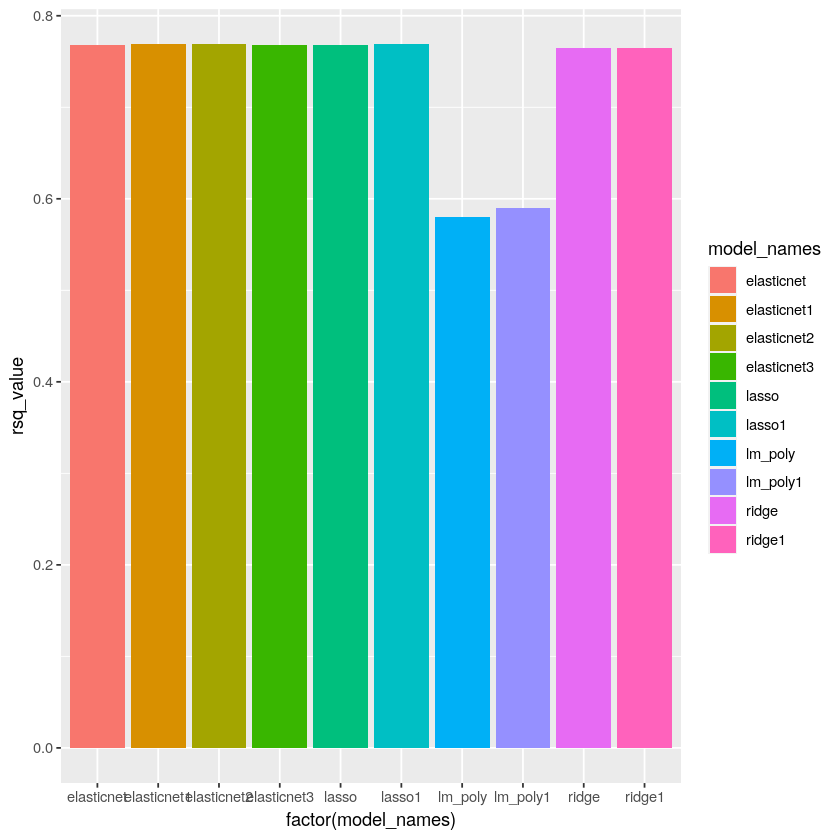

In [46]:
# HINT: Use ggplot() + geom_bar()
ggplot(comparison_df, aes(fill=model_names, y=rsq_value, x=factor(model_names))) + 
    geom_bar(position="dodge", stat="identity")

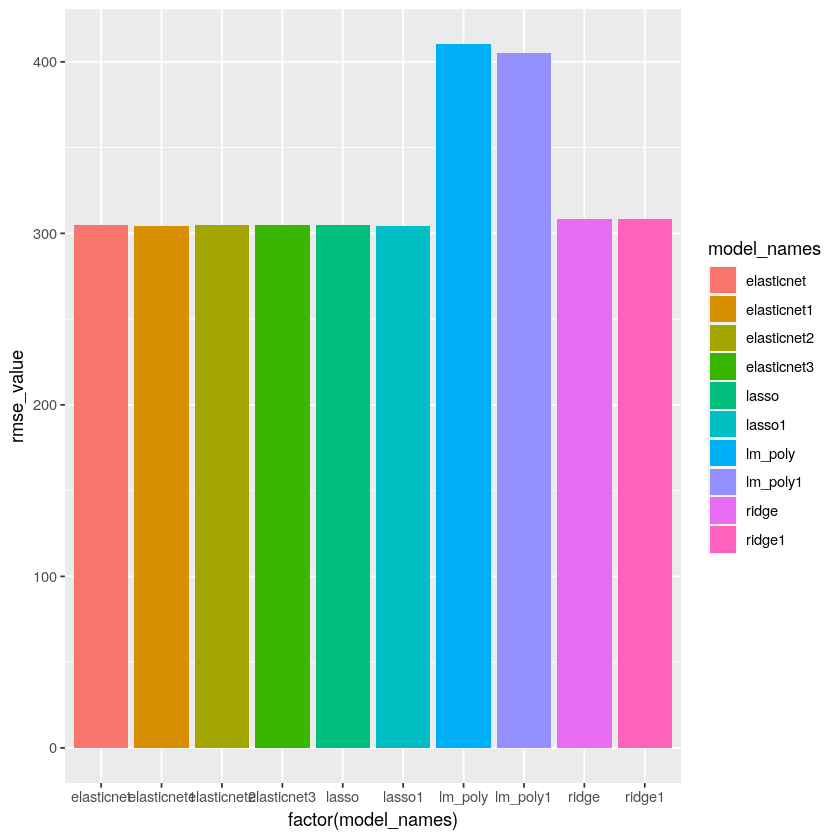

In [47]:
ggplot(comparison_df, aes(fill=model_names, y=rmse_value, x=factor(model_names))) + 
    geom_bar(position="dodge", stat="identity")

*TODO:* Create a Q-Q plot by plotting the distribution difference between the predictions generated by your best model and the true values on the test dataset.


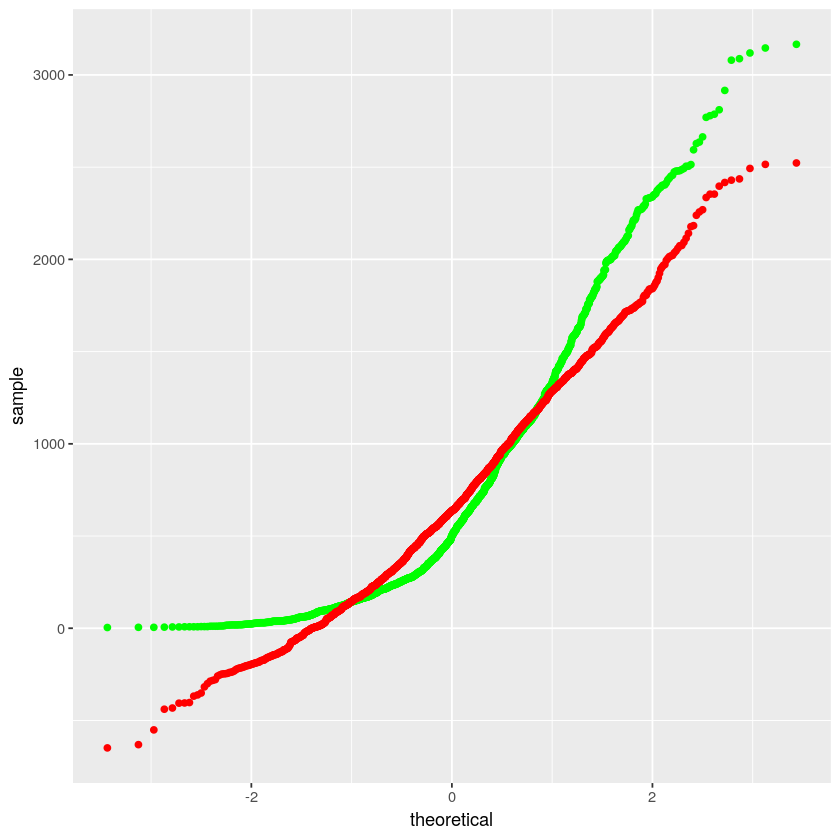

In [48]:
# HINT: Use ggplot() +
    # stat_qq(aes(sample=truth), color='green') +
    # stat_qq(aes(sample=prediction), color='red')
ggplot() +
  stat_qq(aes(sample=test_results_lasso1$truth), color='green') +
  stat_qq(aes(sample=test_results_lasso1$.pred), color='red')

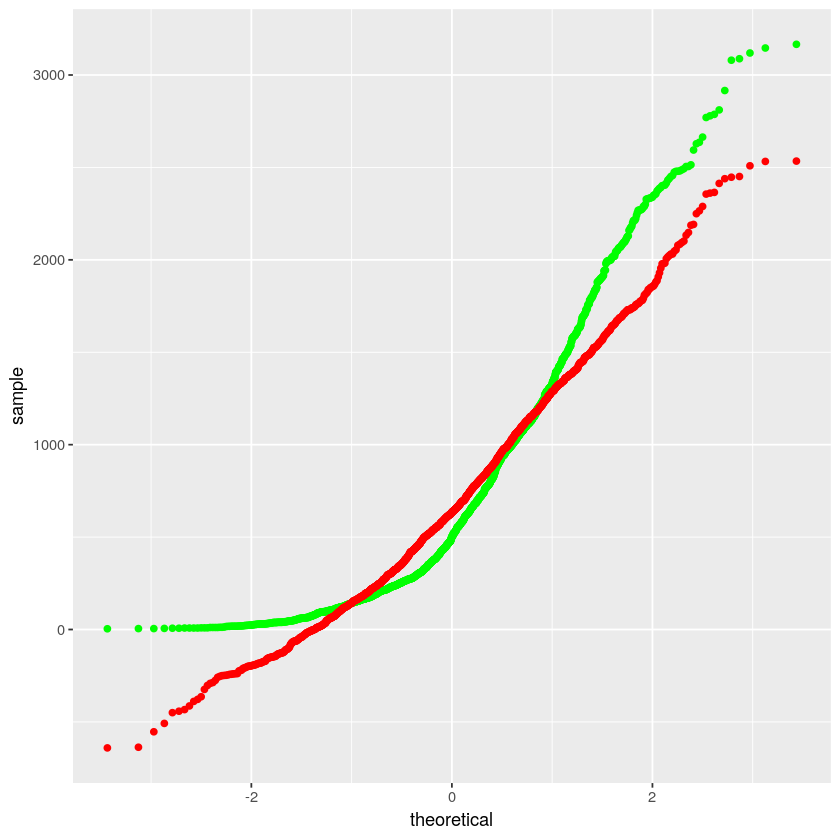

In [49]:
# HINT: Use ggplot() +
    # stat_qq(aes(sample=truth), color='green') +
    # stat_qq(aes(sample=prediction), color='red')
ggplot() +
  stat_qq(aes(sample=test_results_elasticnet1$truth), color='green') +
  stat_qq(aes(sample=test_results_elasticnet1$.pred), color='red')

One example of such Q-Q plot may look like this:


<a href="https://cognitiveclass.ai/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkRP0321ENSkillsNetwork25371262-2021-01-01">
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-RP0321EN-SkillsNetwork/labs/module_4/images/example_qq_plot.png" width="600" align="center">
</a>


# More model improvment methods beyond this course


In addition to the methods mentioned in this lab and previous data analysis courses, you could also explore to try the following methods yourself to see if they could improve model performance:

*   Remove potential redundant variables. If two variables have extremly high correlated, it is possible that they are redundant and could be removed from the model to improve the performance.
*   Remove some outliers. Linear regression models are very sensitive to outliers, you could try to remove some outliers to see if it would improve performance
*   Apply logarithm transformation. In case variable distributions are not normal distribution such as log-normal distribution, you could apply logaritm transformation on the variable to make them more look like normal distribution. In addition, logarithm transformation helps capture the non-linear relationships.

If you have time, you could research and try more methods by searching related research papers/articles, discussion forums, etc. If you know how to use other machine learning models with `Tidymodels` such as Neural Networks, Tree models, or Boosting models, you can also try and compare them with the linear regression models.


# Next Steps:


Great! You have improved your baseline model using polynomial terms, interaction terms, and regularizations, and have found your best model.

Now it's time to build an interactive dashboard to provide more interactive user-interactions.


## Authors

<a href="https://www.linkedin.com/in/yan-luo-96288783/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkRP0321ENSkillsNetwork25371262-2021-01-01" target="_blank">Yan Luo</a>


### Other Contributors

Jeff Grossman


## Change Log

| Date (YYYY-MM-DD) | Version | Changed By | Change Description      |
| ----------------- | ------- | ---------- | ----------------------- |
| 2021-04-08        | 1.0     | Yan        | Initial version created |
|                   |         |            |                         |
|                   |         |            |                         |

## <h3 align="center"> © IBM Corporation 2021. All rights reserved. <h3/>
